# import library

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
print(torch.__version__)


Using CUDA
1.0.1.post2


# Preprocessing data for pytorch
Organize files in different folder for each label and train/test/valid set

In [2]:
from preprocessing import pre_pytorch

walk_dir = 'Large dataset/Gut deformations/Deformed'
target_file_prefix = 'd'
label = 'Deformed'
pre_pytorch(walk_dir, target_file_prefix, label)

walk_dir = 'Large dataset/Gut deformations/Normal'
target_file_prefix = 'n'
label = 'Normal'
pre_pytorch(walk_dir, target_file_prefix, label)


walk_dir (absolute) = /home/ycharn/gut/Large dataset/Gut deformations/Deformed
train_num: 156, test_num: 19, valid_num: 19
walk_dir (absolute) = /home/ycharn/gut/Large dataset/Gut deformations/Normal
train_num: 245, test_num: 31, valid_num: 31


# Tranfer learning
* The code is adopted from [pytorch transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and [kaggle VGG16 tranfer learning](https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch)

## Define the data loader 

In [6]:
data_dir = 'dataset'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=10,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 401 images under train
Loaded 51 images under valid
Loaded 50 images under test
Classes: 
['Deformed', 'Normal']


## Sample visualizations

In [34]:
inputs, classes = next(iter(dataloaders[TRAIN]))
inputs.shape

torch.Size([10, 3, 224, 224])

In [32]:
out = torchvision.utils.make_grid(inputs)

In [35]:
classes

tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0])

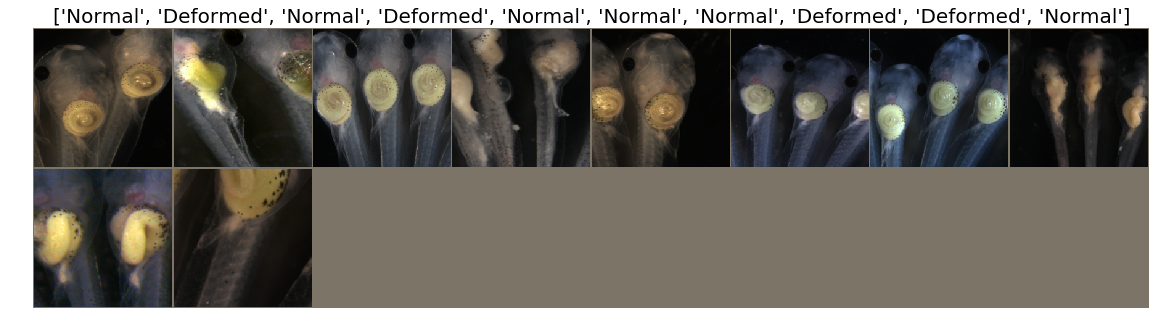

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=20)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

## Define a function to use a model for predictions

In [22]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth for {} batch:".format(i))
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction for {} batch:".format(i))
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state


## Define a function to evalute the model

In [11]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='')

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss_test += loss.data.item()
        #print(loss_test)
        acc_test += torch.sum(preds == labels).item()
        #print(labels.data)
        #print(preds)
        #print(acc_test)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

## Define the network
1. Use the pretrained VGG19
2. Modify the last layer
3. Freeze all previous layers when training

In [14]:
# Load the pretrained model from pytorch
vgg19 = models.vgg19(pretrained=True)
print(vgg19.classifier[6].out_features) # 1000 
# Freeze training for all layers
for param in vgg19.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] # Remove last layer
for f in features:
    for param in f.parameters():
        param.require_grad = False


features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg19.classifier = nn.Sequential(*features) # Replace the model classifier

#num_features = vgg19.classifier[0].in_features
#features = [nn.Linear(num_features, len(class_names))] # Add our layer with 4 outputs
#vgg19.classifier = nn.Sequential(*features) # Replace the model classifier

print(vgg19)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inp

## Define a optimizer

In [16]:
if use_gpu:
    vgg19.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Evaluate the model before training

In [17]:
print("Test before training")
eval_model(vgg19, criterion)

Test before training
Evaluating model
----------
Test batch 0/5

/home/ycharn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 0m 1s
Avg loss (test): 0.0672
Avg acc (test): 0.5600
----------


## Define a training function

In [16]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='')
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train / dataset_sizes[TRAIN]
        avg_acc = acc_train / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='')
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data.item()
            acc_val += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [17]:
vgg19 = train_model(vgg19, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg19.state_dict(), 'VGG19_v2-gut.pt')

Epoch 0/10
----------
Training batch 0/41
Validation batch 0/6

/home/ycharn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 0 result: 
Avg loss (train): 0.0263
Avg acc (train): 0.8753
Avg loss (val): 0.0010
Avg acc (val): 1.0000
----------

Epoch 1/10
----------
Training batch 0/41
Validation batch 0/6
Epoch 1 result: 
Avg loss (train): 0.0173
Avg acc (train): 0.9277
Avg loss (val): 0.0026
Avg acc (val): 1.0000
----------

Epoch 2/10
----------
Training batch 0/41
Validation batch 0/6
Epoch 2 result: 
Avg loss (train): 0.0143
Avg acc (train): 0.9451
Avg loss (val): 0.0006
Avg acc (val): 1.0000
----------

Epoch 3/10
----------
Training batch 0/41
Validation batch 0/6
Epoch 3 result: 
Avg loss (train): 0.0084
Avg acc (train): 0.9751
Avg loss (val): 0.0024
Avg acc (val): 0.9804
----------

Epoch 4/10
----------
Training batch 0/41
Validation batch 0/6
Epoch 4 result: 
Avg loss (train): 0.0092
Avg acc (train): 0.9651
Avg loss (val): 0.0011
Avg acc (val): 1.0000
----------

Epoch 5/10
----------
Training batch 0/41
Validation batch 0/6
Epoch 5 result: 
Avg loss (train): 0.0102
Avg acc (train): 0.9501
Avg

In [20]:
vgg19.load_state_dict(torch.load('VGG19_v2-gut.pt'))
eval_model(vgg19, criterion)

Evaluating model
----------
Test batch 0/5

/home/ycharn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 0m 1s
Avg loss (test): 0.0039
Avg acc (test): 0.9800
----------


/home/ycharn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth for 0 batch:
Prediction for 0 batch:
Ground truth for 1 batch:
Prediction for 1 batch:


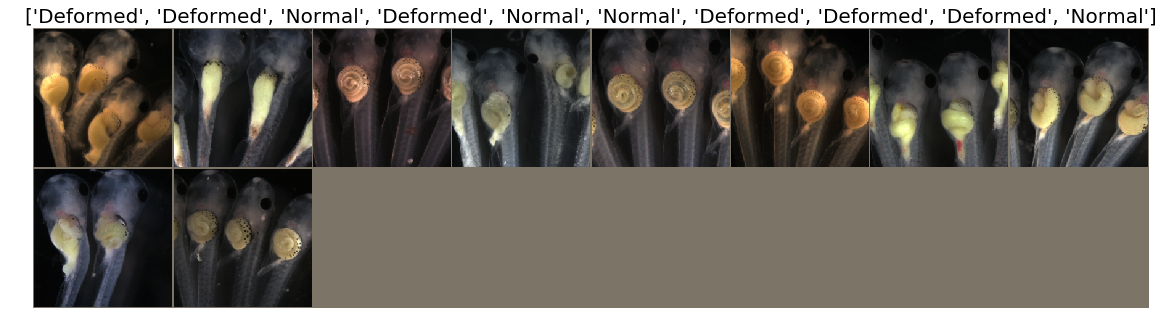

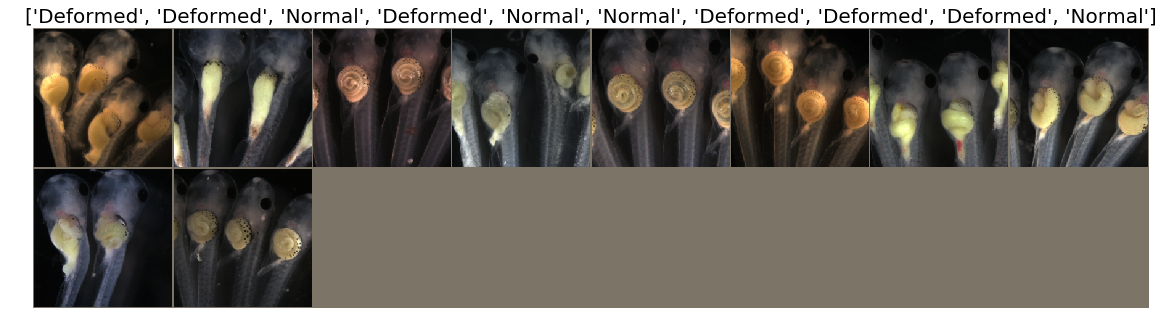

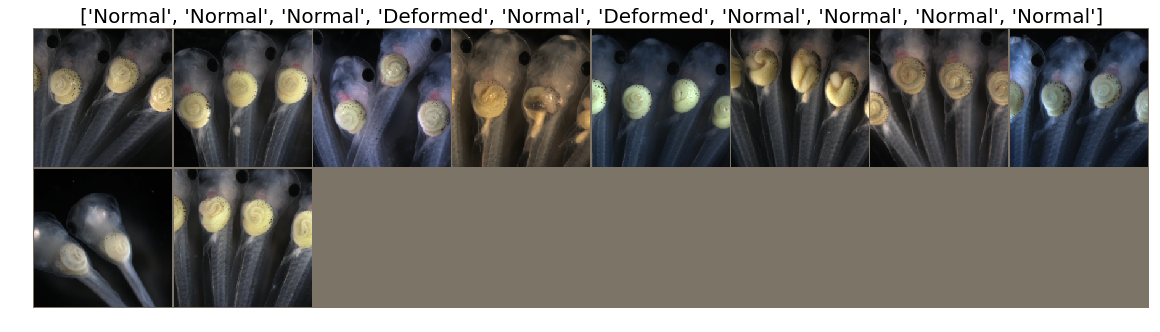

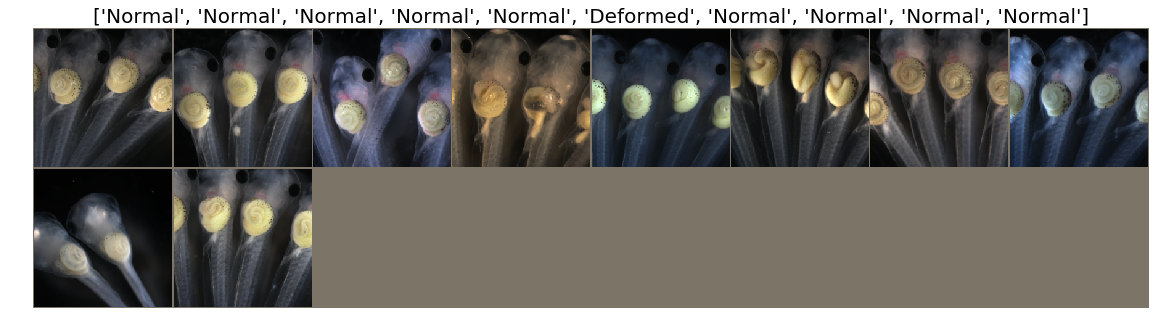

In [23]:
visualize_model(vgg19, num_images=20)